<a href="https://colab.research.google.com/github/kridtapon/CandleFusion/blob/main/CandleFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.8 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to detect bullish and bearish engulfing patterns
def detect_engulfing(df):
    # Previous candle
    prev_open = df['Open'].shift(1)
    prev_close = df['Close'].shift(1)

    # Bullish Engulfing: prev red, current green, body engulfs
    bullish = (prev_close < prev_open) & (df['Close'] > df['Open']) & \
              (df['Open'] < prev_close) & (df['Close'] > prev_open)

    # Bearish Engulfing: prev green, current red, body engulfs
    bearish = (prev_close > prev_open) & (df['Close'] < df['Open']) & \
              (df['Open'] > prev_close) & (df['Close'] < prev_open)

    return bullish, bearish

# Load stock data
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# Detect engulfing patterns
df['Bullish_Engulfing'], df['Bearish_Engulfing'] = detect_engulfing(df)

# Define strategy: Combine candlestick pattern with PVT and Fisher
df['Entry'] = df['Bullish_Engulfing']
df['Exit'] = df['Bearish_Engulfing']

# Filter test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift signals to simulate next-bar execution
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# Create vectorbt portfolio
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Output stats and plot
print(portfolio.stats())
portfolio.plot().show()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-3-7f1b5fa3bdf0>:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shifted_entries = df['Entry'].shift(1).fillna(False).astype(bool).to_numpy()
<ipython-input-3-7f1b5fa3bdf0>:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shifted_exits = df['Exit'].shift(1).fillna(False).astype(bool).to_numpy()


Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  130189.285385
Total Return [%]                               30.189285
Benchmark Return [%]                           187.56104
Max Gross Exposure [%]                             100.0
Total Fees Paid                              4736.062329
Max Drawdown [%]                               71.125254
Max Drawdown Duration                  947 days 00:00:00
Total Trades                                          26
Total Closed Trades                                   26
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   46.153846
Best Trade [%]                                 39.406686
Worst Trade [%]                

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# --- Candlestick Pattern Detection Functions ---

def detect_engulfing(df):
    prev_open = df['Open'].shift(1)
    prev_close = df['Close'].shift(1)

    bullish = (prev_close < prev_open) & (df['Close'] > df['Open']) & \
              (df['Open'] < prev_close) & (df['Close'] > prev_open)

    bearish = (prev_close > prev_open) & (df['Close'] < df['Open']) & \
              (df['Open'] > prev_close) & (df['Close'] < prev_open)

    return bullish, bearish

def detect_pin_bar(df, body_ratio=0.3):
    body = abs(df['Close'] - df['Open'])
    range_ = df['High'] - df['Low']
    upper_wick = df['High'] - df[['Close', 'Open']].max(axis=1)
    lower_wick = df[['Close', 'Open']].min(axis=1) - df['Low']

    bullish = (lower_wick > 2 * body) & (body / range_ < body_ratio)
    bearish = (upper_wick > 2 * body) & (body / range_ < body_ratio)

    return bullish, bearish

def detect_inside_bar(df):
    prev_high = df['High'].shift(1)
    prev_low = df['Low'].shift(1)

    inside = (df['High'] < prev_high) & (df['Low'] > prev_low)
    return inside

def detect_morning_star(df):
    prev = df.shift(1)
    prev2 = df.shift(2)

    cond1 = prev2['Close'] < prev2['Open']  # bearish candle
    cond2 = abs(prev['Close'] - prev['Open']) / (prev['High'] - prev['Low']) < 0.3  # small candle (doji or spinning)
    cond3 = df['Close'] > df['Open']  # bullish candle
    cond4 = df['Close'] > prev2['Open']  # bullish close above first candle open

    return cond1 & cond2 & cond3 & cond4

def detect_evening_star(df):
    prev = df.shift(1)
    prev2 = df.shift(2)

    cond1 = prev2['Close'] > prev2['Open']  # bullish candle
    cond2 = abs(prev['Close'] - prev['Open']) / (prev['High'] - prev['Low']) < 0.3  # small candle
    cond3 = df['Close'] < df['Open']  # bearish candle
    cond4 = df['Close'] < prev2['Open']  # bearish close below first candle open

    return cond1 & cond2 & cond3 & cond4

# --- Load Data ---
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# --- Apply Pattern Detection ---
df['Bullish_Engulfing'], df['Bearish_Engulfing'] = detect_engulfing(df)
df['Bullish_Pin'], df['Bearish_Pin'] = detect_pin_bar(df)
df['Inside_Bar'] = detect_inside_bar(df)
df['Morning_Star'] = detect_morning_star(df)
df['Evening_Star'] = detect_evening_star(df)

# --- Strategy Logic (combine signals) ---
df['Entry'] = (
    df['Bullish_Engulfing'] |
    df['Bullish_Pin'] |
    df['Morning_Star']
)

df['Exit'] = (
    df['Bearish_Engulfing'] |
    df['Bearish_Pin'] |
    df['Evening_Star']
)

# Optional: use Inside Bar as filter (e.g., only trade if Inside Bar preceded signal)
# Uncomment to apply:
# df['Entry'] = df['Entry'] & df['Inside_Bar'].shift(1)
# df['Exit'] = df['Exit'] & df['Inside_Bar'].shift(1)

# --- Filter Date Range ---
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# --- Shift Signals for Next-Bar Execution ---
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# --- Portfolio Simulation ---
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# --- Output Results ---
print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                               2020-01-02 00:00:00
End                                 2024-12-31 00:00:00
Period                               1258 days 00:00:00
Start Value                                    100000.0
End Value                                  93598.165922
Total Return [%]                              -6.401834
Benchmark Return [%]                          187.56104
Max Gross Exposure [%]                            100.0
Total Fees Paid                            11292.748516
Max Drawdown [%]                              59.086291
Max Drawdown Duration                1225 days 00:00:00
Total Trades                                         85
Total Closed Trades                                  85
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  43.529412
Best Trade [%]                                56.974813
Worst Trade [%]                              -24

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# --- MACD Calculation Function ---
def calculate_macd(close, fast_period=12, slow_period=26, signal_period=9):
    ema_fast = close.ewm(span=fast_period, adjust=False).mean()
    ema_slow = close.ewm(span=slow_period, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal

# --- Candlestick Pattern Detection Functions ---

def detect_engulfing(df):
    prev_open = df['Open'].shift(1)
    prev_close = df['Close'].shift(1)

    bullish = (prev_close < prev_open) & (df['Close'] > df['Open']) & \
              (df['Open'] < prev_close) & (df['Close'] > prev_open)

    bearish = (prev_close > prev_open) & (df['Close'] < df['Open']) & \
              (df['Open'] > prev_close) & (df['Close'] < prev_open)

    return bullish, bearish

def detect_pin_bar(df, body_ratio=0.3):
    body = abs(df['Close'] - df['Open'])
    range_ = df['High'] - df['Low']
    upper_wick = df['High'] - df[['Close', 'Open']].max(axis=1)
    lower_wick = df[['Close', 'Open']].min(axis=1) - df['Low']

    bullish = (lower_wick > 2 * body) & (body / range_ < body_ratio)
    bearish = (upper_wick > 2 * body) & (body / range_ < body_ratio)

    return bullish, bearish

def detect_inside_bar(df):
    prev_high = df['High'].shift(1)
    prev_low = df['Low'].shift(1)

    inside = (df['High'] < prev_high) & (df['Low'] > prev_low)
    return inside

def detect_morning_star(df):
    prev = df.shift(1)
    prev2 = df.shift(2)

    cond1 = prev2['Close'] < prev2['Open']  # bearish candle
    cond2 = abs(prev['Close'] - prev['Open']) / (prev['High'] - prev['Low']) < 0.3  # small candle (doji or spinning)
    cond3 = df['Close'] > df['Open']  # bullish candle
    cond4 = df['Close'] > prev2['Open']  # bullish close above first candle open

    return cond1 & cond2 & cond3 & cond4

def detect_evening_star(df):
    prev = df.shift(1)
    prev2 = df.shift(2)

    cond1 = prev2['Close'] > prev2['Open']  # bullish candle
    cond2 = abs(prev['Close'] - prev['Open']) / (prev['High'] - prev['Low']) < 0.3  # small candle
    cond3 = df['Close'] < df['Open']  # bearish candle
    cond4 = df['Close'] < prev2['Open']  # bearish close below first candle open

    return cond1 & cond2 & cond3 & cond4


# --- Load Data ---
symbol = 'SMCI'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# --- Calculate MACD using the function ---
df['MACD'], df['Signal'] = calculate_macd(df['Close'])

# --- Generate MACD crossover signals ---
df['MACD_Bullish'] = (df['MACD'] > df['Signal'])
df['MACD_Bearish'] = (df['MACD'] < df['Signal'])

# --- Apply Pattern Detection ---
df['Bullish_Engulfing'], df['Bearish_Engulfing'] = detect_engulfing(df)
df['Bullish_Pin'], df['Bearish_Pin'] = detect_pin_bar(df)
df['Inside_Bar'] = detect_inside_bar(df)
df['Morning_Star'] = detect_morning_star(df)
df['Evening_Star'] = detect_evening_star(df)

# --- Strategy Logic (combine candlestick and MACD signals) ---
df['Entry'] = (
    (df['Bullish_Engulfing'] | df['Bullish_Pin'] | df['Morning_Star'] | df['Inside_Bar'].shift(1)) &
    df['MACD_Bullish']
)

df['Exit'] = (
    (df['Bearish_Engulfing'] | df['Bearish_Pin'] | df['Evening_Star'] | df['Inside_Bar'].shift(1)) &
    df['MACD_Bearish']
)

# --- Filter Date Range ---
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# --- Shift signals for next-bar execution ---
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# --- Portfolio Simulation ---
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# --- Output Results ---
print(portfolio.stats())
portfolio.plot().show()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  248107.127252
Total Return [%]                              148.107127
Benchmark Return [%]                         1194.339663
Max Gross Exposure [%]                             100.0
Total Fees Paid                             19124.954949
Max Drawdown [%]                               77.691526
Max Drawdown Duration                  544 days 00:00:00
Total Trades                                          38
Total Closed Trades                                   38
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   39.473684
Best Trade [%]                                136.505322
Worst Trade [%]                

[*********************100%***********************]  1 of 1 completed
100%|██████████| 2541/2541 [03:33<00:00, 11.91it/s]



Best Params: Fast=5, Slow=13, Signal=6 -> Total Return [%]: 2482.80


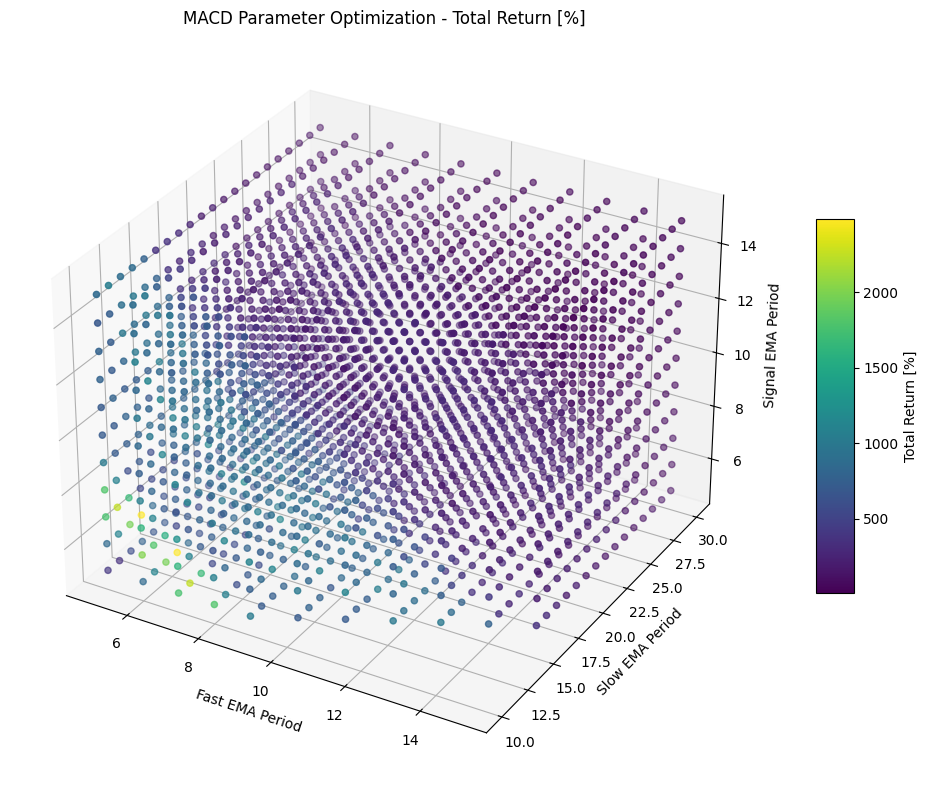

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product
from tqdm import tqdm  # for progress bar

# --- MACD Calculation Function ---
def calculate_macd(close, fast_period, slow_period, signal_period):
    ema_fast = close.ewm(span=fast_period, adjust=False).mean()
    ema_slow = close.ewm(span=slow_period, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal

# --- Pattern Detection Functions ---
def detect_engulfing(df):
    prev_open = df['Open'].shift(1)
    prev_close = df['Close'].shift(1)
    bullish = (prev_close < prev_open) & (df['Close'] > df['Open']) & (df['Open'] < prev_close) & (df['Close'] > prev_open)
    bearish = (prev_close > prev_open) & (df['Close'] < df['Open']) & (df['Open'] > prev_close) & (df['Close'] < prev_open)
    return bullish, bearish

def detect_pin_bar(df, body_ratio=0.3):
    body = abs(df['Close'] - df['Open'])
    range_ = df['High'] - df['Low']
    upper_wick = df['High'] - df[['Close', 'Open']].max(axis=1)
    lower_wick = df[['Close', 'Open']].min(axis=1) - df['Low']
    bullish = (lower_wick > 2 * body) & (body / range_ < body_ratio)
    bearish = (upper_wick > 2 * body) & (body / range_ < body_ratio)
    return bullish, bearish

def detect_inside_bar(df):
    prev_high = df['High'].shift(1)
    prev_low = df['Low'].shift(1)
    inside = (df['High'] < prev_high) & (df['Low'] > prev_low)
    return inside

def detect_morning_star(df):
    prev = df.shift(1)
    prev2 = df.shift(2)
    cond1 = prev2['Close'] < prev2['Open']
    cond2 = abs(prev['Close'] - prev['Open']) / (prev['High'] - prev['Low']) < 0.3
    cond3 = df['Close'] > df['Open']
    cond4 = df['Close'] > prev2['Open']
    return cond1 & cond2 & cond3 & cond4

def detect_evening_star(df):
    prev = df.shift(1)
    prev2 = df.shift(2)
    cond1 = prev2['Close'] > prev2['Open']
    cond2 = abs(prev['Close'] - prev['Open']) / (prev['High'] - prev['Low']) < 0.3
    cond3 = df['Close'] < df['Open']
    cond4 = df['Close'] < prev2['Open']
    return cond1 & cond2 & cond3 & cond4

# --- Load Data ---
symbol = 'SMCI'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# --- Detect Patterns ---
df['Bullish_Engulfing'], df['Bearish_Engulfing'] = detect_engulfing(df)
df['Bullish_Pin'], df['Bearish_Pin'] = detect_pin_bar(df)
df['Inside_Bar'] = detect_inside_bar(df)
df['Morning_Star'] = detect_morning_star(df)
df['Evening_Star'] = detect_evening_star(df)

# --- Define parameter ranges ---
fast_range = range(5, 16)
slow_range = range(10, 31)
signal_range = range(5, 16)

results = []

# --- Optimization Loop ---
for fast, slow, signal in tqdm(product(fast_range, slow_range, signal_range), total=len(fast_range)*len(slow_range)*len(signal_range)):
    if fast >= slow:
        continue  # skip invalid combinations

    df['MACD'], df['Signal'] = calculate_macd(df['Close'], fast, slow, signal)
    df['MACD_Bullish'] = (df['MACD'] > df['Signal'])
    df['MACD_Bearish'] = (df['MACD'] < df['Signal'])

    df['Entry'] = (
        (df['Bullish_Engulfing'] | df['Bullish_Pin'] | df['Morning_Star'] | df['Inside_Bar'].shift(1)) &
        df['MACD_Bullish']
    )

    df['Exit'] = (
        (df['Bearish_Engulfing'] | df['Bearish_Pin'] | df['Evening_Star'] | df['Inside_Bar'].shift(1)) &
        df['MACD_Bearish']
    )

    filtered_df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
    entries = filtered_df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
    exits = filtered_df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

    try:
        portfolio = vbt.Portfolio.from_signals(
            close=filtered_df['Open'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001,
            slippage=0.002,
            freq='D'
        )
        total_return = portfolio.stats()['Total Return [%]']
        results.append(((fast, slow, signal), total_return))
    except Exception as e:
        continue

# --- Sort and show best parameters ---
results.sort(key=lambda x: x[1], reverse=True)
best_params, best_value = results[0]
print(f"\nBest Params: Fast={best_params[0]}, Slow={best_params[1]}, Signal={best_params[2]} -> Total Return [%]: {best_value:.2f}")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 3D Plot of Optimization Results ---
# Extract fast, slow, signal, and value
fast_vals = [r[0][0] for r in results]
slow_vals = [r[0][1] for r in results]
signal_vals = [r[0][2] for r in results]
final_vals = [r[1] for r in results]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Use color to represent the value (e.g., with a colormap)
sc = ax.scatter(fast_vals, slow_vals, signal_vals, c=final_vals, cmap='viridis', marker='o')

# Labels and Title
ax.set_xlabel('Fast EMA Period')
ax.set_ylabel('Slow EMA Period')
ax.set_zlabel('Signal EMA Period')
ax.set_title('MACD Parameter Optimization - Total Return [%]')

# Add colorbar to show value scale
fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10, label='Total Return [%]')

plt.tight_layout()
plt.show()


In [7]:
# --- Calculate MACD using the function ---
df['MACD'], df['Signal'] = calculate_macd(df['Close'], fast_period=5, slow_period=13, signal_period=6)

# --- Generate MACD crossover signals ---
df['MACD_Bullish'] = (df['MACD'] > df['Signal'])
df['MACD_Bearish'] = (df['MACD'] < df['Signal'])

# --- Apply Pattern Detection ---
df['Bullish_Engulfing'], df['Bearish_Engulfing'] = detect_engulfing(df)
df['Bullish_Pin'], df['Bearish_Pin'] = detect_pin_bar(df)
df['Inside_Bar'] = detect_inside_bar(df)
df['Morning_Star'] = detect_morning_star(df)
df['Evening_Star'] = detect_evening_star(df)

# --- Strategy Logic (combine candlestick and MACD signals) ---
df['Entry'] = (
    (df['Bullish_Engulfing'] | df['Bullish_Pin'] | df['Morning_Star'] | df['Inside_Bar'].shift(1)) &
    df['MACD_Bullish']
)

df['Exit'] = (
    (df['Bearish_Engulfing'] | df['Bearish_Pin'] | df['Evening_Star'] | df['Inside_Bar'].shift(1)) &
    df['MACD_Bearish']
)

# --- Filter Date Range ---
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# --- Shift signals for next-bar execution ---
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# --- Portfolio Simulation ---
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# --- Output Results ---
print(portfolio.stats())
portfolio.plot().show()

Start                               2020-01-02 00:00:00
End                                 2024-12-31 00:00:00
Period                               1258 days 00:00:00
Start Value                                    100000.0
End Value                                2582796.915646
Total Return [%]                            2482.796916
Benchmark Return [%]                        1194.339663
Max Gross Exposure [%]                            100.0
Total Fees Paid                            66840.631583
Max Drawdown [%]                              57.859185
Max Drawdown Duration                 133 days 00:00:00
Total Trades                                         60
Total Closed Trades                                  59
Total Open Trades                                     1
Open Trade PnL                            -42159.946666
Win Rate [%]                                  50.847458
Best Trade [%]                                127.84903
Worst Trade [%]                              -23